In [1]:
# импортируем библиотеки для работы с данными
import pandas as pd
from sklearn import preprocessing 

# загрузим данные
df = pd.read_csv("data/segmented_customers.csv")
# посмотрим на данные
df.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
0,1,Male,19.0,15.0,39.0,4.0
1,2,Male,21.0,15.0,81.0,3.0
2,3,Female,20.0,16.0,6.0,4.0
3,4,Female,23.0,16.0,77.0,3.0
4,5,Female,31.0,17.0,40.0,4.0


In [2]:
# посмотрим, есть ли пропуски в датасете
df[df.isna().any(axis=1)]

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100),cluster
200,201,Female,21.0,NaN,40.0,0.0
201,202,Female,30.0,127.0,NaN,NaN
202,203,Male,80.0,NaN,20.0,NaN
203,204,Male,NaN,16.0,120.0,NaN
204,205,Female,NaN,9.0,80.0,NaN


In [3]:
# пропусков не так много, поэтому мы можем удалить данные с пропусками
df = df.dropna()

# переименуем столбцы для более удобной работы
df.rename(columns = {'CustomerID' : 'customer_id', 'Gender' : 'gender', 
                    'Age': 'age', 'Annual Income (k$)': 'annual_income', 
                    'Spending Score (1-100)': 'spending_score', }, inplace = True)

In [4]:
# проверим, есть ли в данных дубликаты
df[df.duplicated(subset=['customer_id'])]

,customer_id,gender,age,annual_income,spending_score,cluster


In [5]:
import plotly
import plotly.express as px

# передаём датафрейм и поля, которые нужно использовать для осей абсцисс, ординат и аппликат
fig = px.scatter_3d(
    data_frame=df, 
    x = 'age', 
    y = 'annual_income', 
    z = 'spending_score', 
    width=1000,
    height=700
)

#отображаем график
fig.show()

Так как нам часто будет требоваться визуализировать результаты кластеризации, напишем для этого функцию. Она будет принимать датафрейм и название столбца датафрейма с результатами кластеризации. Так как нас будут стабильно интересовать три столбца (age, annual_income, spending_score), зафиксируем их названия внутри функции:

In [6]:
def get_3d_visualization(df, clust_res):
    fig = px.scatter_3d(
        data_frame=df, 
        x = 'age', 
        y = 'annual_income', 
        z = 'spending_score', 
        color = clust_res,
        width=1000,
        height=700
    )

    #возвращаем график
    return fig

In [7]:
X = df[['age', 'annual_income', 'spending_score']]

In [8]:
import seaborn as sns

In [16]:
from sklearn.cluster import DBSCAN
clastering = DBSCAN().fit_predict(X)
X['clusters'] = clastering
fig = px.scatter_3d(data_frame=X, x='age', y='annual_income', z='spending_score', color = 'clusters')
fig.show()

C:\Users\Настенька\AppData\Local\Temp\ipykernel_36240\3763563580.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [22]:
# импортируем DBSCAN-кластеризацию
from sklearn.cluster import DBSCAN

#запускаем кластеризацию на наших данных
dbscan = DBSCAN(eps=11)
clustering_dbscan_res = dbscan.fit_predict(X)
df['dbscan_res_eps_11'] = clustering_dbscan_res

get_3d_visualization(df, 'dbscan_res_eps_11')

Проведём агломеративную кластеризацию, чтобы построить дендрограмму и по ней оценить количество кластеров, на которое можно разделить датасет. Напишем функцию, которая будет принимать количество кластеров и матрицу с признаками:

In [23]:
# импортируем алгомеративную кластеризацию из sklearn
from sklearn.cluster import AgglomerativeClustering

# напишем функцию, которая будет проводить алгомеративную кластеризацию
# на вход она будет принимать X — матрицу с признаками для кластеризации и n_clusters — количество кластеров,
# на выходе будет возвращать список с номерами кластеров
def get_aggl_clustering(X, n_clusters):
    # запустим агломеративную кластеризацию
    agglomerative_clustering = AgglomerativeClustering(n_clusters=n_clusters, linkage='ward')
    # обучим модель агломеративной кластеризации
    agglomerative_clustering.fit(X)
    # получим список c информацией, к какому кластеру относятся объекты
    aggl_prediction = agglomerative_clustering.labels_
    # вернём список с результатами
    return aggl_prediction

In [42]:
df['aggl_res'] = get_aggl_clustering(X, 3)

In [37]:
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt

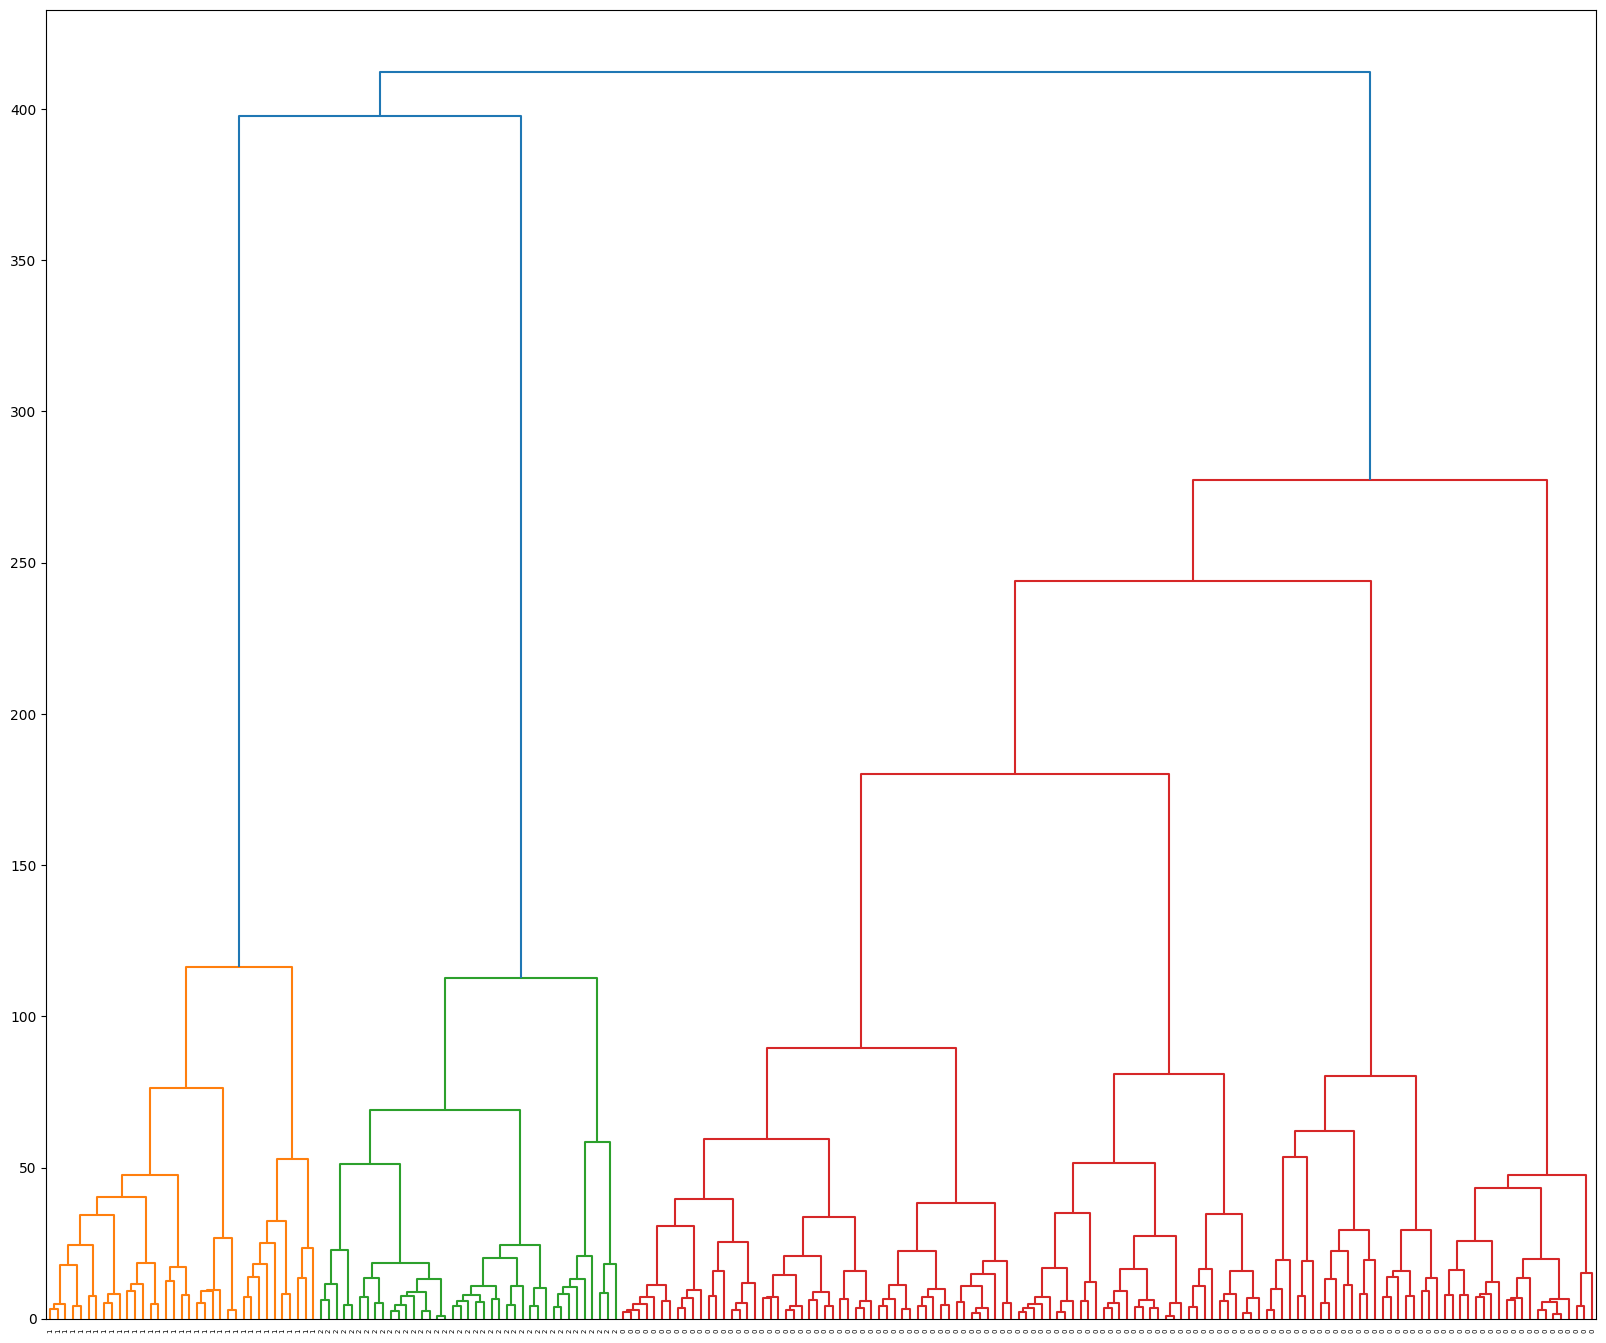

In [43]:
linked = linkage(X, 'ward')
plt.figure (figsize = (20,17))
dendrogram(Z=linked, orientation='top', labels = df['aggl_res'].to_list(), distance_sort='descending',  show_leaf_counts=True)
plt.show()

In [44]:
df['aggl_res_6'] = get_aggl_clustering(df[['age', 'annual_income', 'spending_score']], 6)
get_3d_visualization(df, 'aggl_res_6')

<Axes: xlabel='cluster', ylabel='silhouette'>

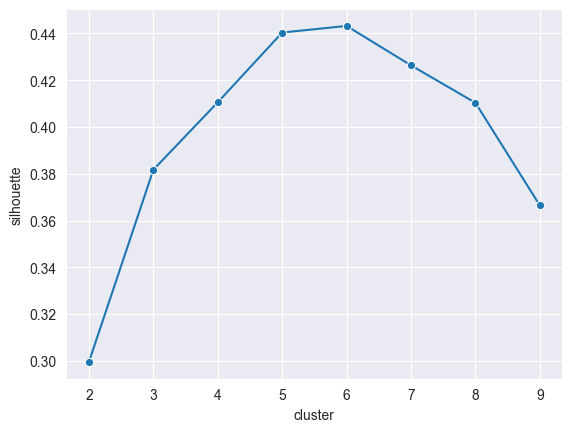

In [45]:
# импортируем метрику силуэт
from sklearn.metrics import silhouette_score

# напишем функцию, как и при подсчете метода локтя
def get_silhouette(cluster_num, X):
    res = get_aggl_clustering(X, cluster_num)
# подсчитаем метрику силуэта, передав данные и то, к каким кластерам относятся объекты
    silhouette = silhouette_score(X, res)
    return silhouette

# создадим пустой словарь, ключами будут инерция и количество кластеров
silhouette_res = {"silhouette": [], "cluster": []}

for cluster_num in range(2, 10):
    silhouette_res["silhouette"].append(get_silhouette(cluster_num, X))
    silhouette_res["cluster"].append(cluster_num)
    
# сохраним в датафрейм значение силуэта и количество кластеров
silhouette_df = pd.DataFrame(silhouette_res)

# установим стиль для визуализиции
sns.set_style("darkgrid")
# визуализируем зависимость значения инерции от количества кластеров
sns.lineplot(data=silhouette_df, x="cluster", y="silhouette", marker= "o")

In [46]:
from sklearn.metrics.cluster import completeness_score

print(completeness_score(labels_true=df.cluster, labels_pred=df.aggl_res_6))

0.9012847747610448
